In [1]:
import matplotlib.pyplot as plt
from typing import Literal

E, A, B = 1.69, 406.4, 410.7
alpha, beta = .34, .28
G = (alpha * A/(beta * B)) ** (1/(alpha + beta))


a_K, b_K = .73, .27
a_C, b_C =  .46, .54


In [2]:
def chinchilla_loss(N, D, irr_loss = False):
    return (0 if not irr_loss else E) + A/(N ** alpha) + B/(D ** beta)

def N_opt(C, paper = Literal['kaplan', 'chinchila']):
    if (paper == 'kaplan'):
        return 9e-7 * C**a_K
    elif paper == 'chinchilla':
        return G * (C/6) ** a_C

def D_opt(C, paper = Literal['kaplan', 'chinchila']):
    if (paper == 'kaplan'):
        return 1/(6 * 9e-7) * C**b_K
    elif paper == 'chinchilla':
        return (1/G) * (C/6) ** b_C


def chinchilla_optimal(C):
    return chinchilla_loss(N_opt(C, 'chinchilla'), D_opt(C, 'chinchilla')) 



def kaplan_optimal(C):
    return chinchilla_loss(N_opt(C, 'kaplan'), D_opt(C, 'kaplan')) 

In [3]:
Cs = [10 ** i for i in range(15, 30)]

[N_opt(C, 'kaplan') * D_opt(C, 'kaplan') * 6/C for C in Cs]
# [N_opt(C, 'chinchilla') * D_opt(C, 'chinchilla') * 6/C for C in Cs]

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0000000000000002,
 1.0,
 1.0000000000000002]

[0.9157800556875879, 0.6434904235661976, 0.45217634888355207, 0.31775208316348125, 0.22329743762838278, 0.15692560134130557, 0.11028553422330067, 0.07751003739572494, 0.05447684453745, 0.03828957096096473]


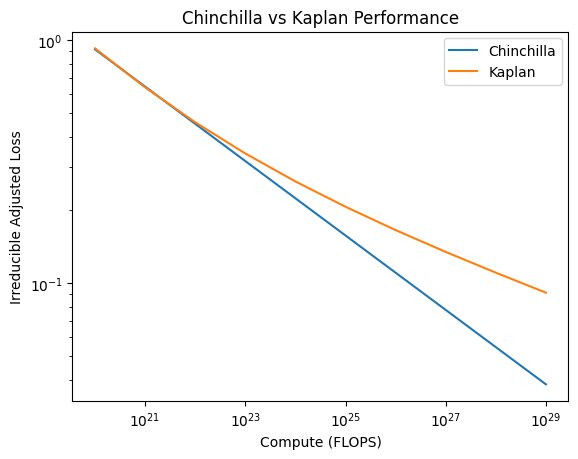

In [ ]:
Cs = [10 ** i for i in range(20, 30)]
plt.plot(Cs, list(map(chinchilla_optimal, Cs)), label = 'Chinchilla')
plt.plot(Cs, list(map(kaplan_optimal, Cs)), label = 'Kaplan')
print(list(map(chinchilla_optimal, Cs)))
plt.yscale('log')
plt.title('Chinchilla vs Kaplan Performance')
plt.xlabel('Compute (FLOPS)')
plt.ylabel('Irreducible Adjusted Loss')
plt.xscale('log')
plt.legend()

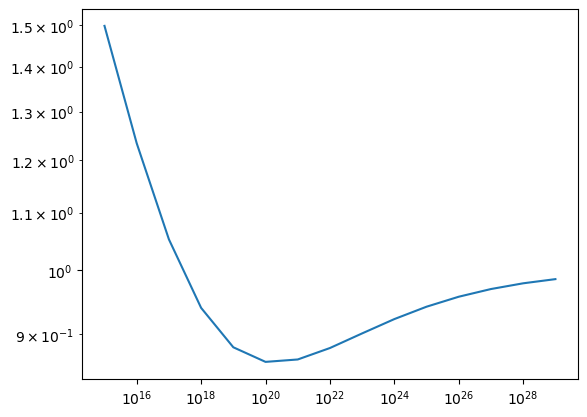

In [37]:
plt.plot(Cs, list(map(lambda s: kaplan_optimal(s) / chinchilla_optimal(s), Cs)), label = 'Kaplan')
plt.yscale('log')
plt.xscale('log')